In [1]:
import os

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from scipy.optimize import curve_fit
from scipy.integrate import simpson
from scipy import stats

from csv import writer




# 1. Введение
Волоконные лазеры высокой мощности являются перспективным направлением развития волоконной оптичики. Однако присутсвие большой световой мощности в узком световоде влечет за собой ухудшения качества излучения. 

Во-первых, начиная с некоторой порговой мощности начинают проялвеяться нелинейный эффекты. Наиболее деструктивным из них является появление вынужденного комбинационного рассеяния (ВКР, рамановское излучение), т.е перекачки мощности из основной спектральной кмпоненты на смещенную. Этот эффект хорошо описан в литературе.

Во-вторых, так же вследвие нелинейных эффектов может уширяться спектральный пик основной компоненты излучения $\Delta\lambda$, что тоже является нежелательным эффектом. Причиной этому являнию могут послужить множество различных факторов. 

Вышеперечисленные нелинейные эффекты, особенно уширение спектра, напрямую можно отследить при помощи спектранализатора. Поэтому для прикладных задач интересно определить наличие корреляции с прочими макроскопическими параметрами, например, с температурой $T$ важных оптических компонент волоконного лазера. Сама температура зависит от многих факторов, вособенности от конфигурации охлаждающей системы и времени работы лазера, поэтому говорить о теоретической зависимости тяжело, но можно оценить наличие корреляции между вышеупомянутыми величинами.

# Цели работы: 
1. Проверить теоретические зависимости величины рамановского сигнала от мощности излучения в волокне.
2. Убедиться, что ширина спектра излучения коррелирует с  


# 2. Калибровочные зависимости мощности от силы тока
Имеется файл с данными о зависимости выходной мощности $Pout$ и температуры высвета $T$ (фрагмента волокна, покрытого высвечивающим полимером) от процента тока накачки $I$ относительно максимального.

Выходная мощость определена измереителем мощности FieldMax, тмепература измерена тепловизором Fluke.

Считаем эти данные из файла и построим зависимости мощности от тока накачки и температуры высвета от мощности излучения.

Из графика видно, что зависимость выходной мощности не совсем линейная при маленьких значениях тока.  Поэтому воспользуемся функцией линейной интерполяции.
То же самое было сделано для температуры, поскольку теоретические зависимости этих величин достаточно сложны.

Pnom =  30
y [30.0, 30.0, 55.8, 121.9, 190.0, 255.0, 312.0, 390.0, 450.0, 504.0, 560.0]
T [26.0, 26.0, 31.6, 39.0, 41.0, 47.0, 45.0, 50.0, 52.0, 57.1, 61.0]
Pnom =  42
y [40.0, 40.0, 65.0, 133.1, 195.0, 263.0, 327.0, 396.0, 452.0, 520.0, 584.0]
T [29.0, 29.0, 36.0, 41.0, 43.0, 46.0, 49.0, 49.0, 50.3, 52.2, 54.0]
Pnom =  56
y [50.0, 52.1, 78.0, 143.0, 210.0, 276.0, 340.0, 405.0, 468.0, 532.0, 592.0]
T [33.7, 33.0, 36.6, 40.9, 43.8, 48.0, 49.0, 50.3, 53.5, 54.0, 57.3]


Text(0, 0.5, 'T, $\\degree C$')

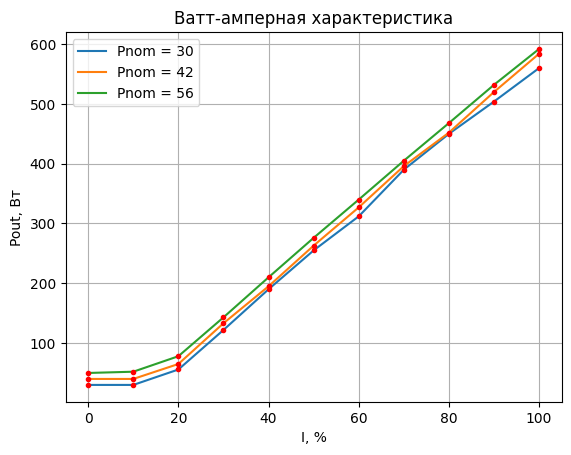

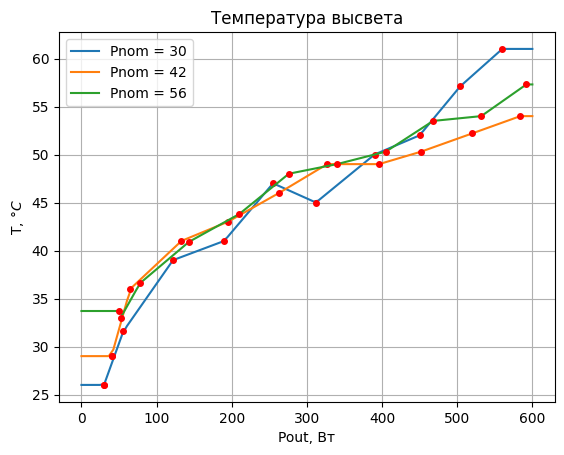

In [2]:

# Считываем файл
Pout_data = pd.read_csv('Pout_data.dat', sep = '\t')
I = Pout_data.iloc[:, 0]

Powers =['30', '42', '56']
Power_lambdas = dict.fromkeys(Powers) 
Temp_lambdas = dict.fromkeys(Powers) 
# Temp_lambdas_2 = dict.fromkeys(Powers) 

def get_power(P_nom, Iproc ):
    return Power_lambdas[P_nom](Iproc)

def get_temp(P_nom, Pout ):
    return Temp_lambdas[P_nom](Pout)

 
fig1, ax1 = plt.subplots()
fig2, ax2 = plt.subplots()
ii = np.linspace(0, 100, 101)
pp = np.linspace(0, 600, 100)
for power in Powers:
    print('Pnom = ', power)
    P = [float(a.replace(',', '.')) for a in Pout_data['Pout' + power]]
    T = [float(a.replace(',', '.')) for a in Pout_data['T' + power]]
    print('y', P)
    print('T', T)
    p = lambda i, I = I, P = P: np.interp(i, I, P) 
    t = lambda i, P = P, T = T: np.interp(i, P, T) 
    Power_lambdas[power] = p
    Temp_lambdas[power] = t

    ax1.plot(ii, get_power(power, ii),  label = 'Pnom = ' + power)
    ax1.plot(I, P, 'ro', markersize = 3)    
    ax2.plot(pp, get_temp(power, pp),  label = 'Pnom = ' + power)
    ax2.plot(P, T, 'ro', markersize = 4)
    

       
ax1.legend()
ax1.grid()
ax1.set_title('Ватт-амперная характеристика')
ax1.set_xlabel('I, %')
ax1.set_ylabel('Pout, Вт')

ax2.legend()
ax2.grid()
ax2.set_title('Температура высвета')
ax2.set_xlabel('Pout, Вт')
ax2.set_ylabel(r'T, $\degree C$')



# 2. Ширина спектральных пиков излучения
Считаем спектры из файлов в директории `600//`. В названиях файлов отражены номинальная мощность задающего лазера и ток накачки усилителя. Постфиксом `'-1'` помечены файлы, содержащие информацию о рамановском излучении.

Сохраним информацию ввиде словаря, содержащего значения выходной мощности, массива длин волн и спектра излучения в размерности дБм.  

In [3]:

def read_spectrum(f:str):
    Pnom = f.split('//')[-1].split('.')[0].split('-')[0]
    Iproc = f.split('//')[-1].split('.')[0].split('-')[1]
    Pout = get_power(Pnom, float(Iproc))

    colnames = ['nm', 'dBm']
    scan = pd.read_csv(f, skiprows = 29, names=colnames)

    lmbdas = scan['nm']
    value = scan['dBm']
    return {'Pout': Pout, 
            'lmbdas' :lmbdas,
            'value': value}

path = '600//'

non_raman = {'30': {'data':[] }, 
             '42': {'data':[] }, 
             '56': {'data':[] }}

raman = {'56': {'data':[] }}


for name in os.listdir(path):
    f = os.path.join(path, name)
    # print(f, os.path.isfile(f), name[-4:])
    if os.path.isfile(f) and name[-4:] == '.CSV':

        spectrum = read_spectrum(f)
        split = name.split('.')[0].split('-')

        if len(split) == 2:
            non_raman[split[0]]['data'].append(spectrum)
            # print(len(non_raman[split[0]]['data']))

        elif len(split) == 3:
            raman[split[0]]['data'].append(spectrum)
            # print(len(raman[split[0]]['data']))


(1072.2967, 1.0566999999998643, -27.021, 0.8441467987333563)

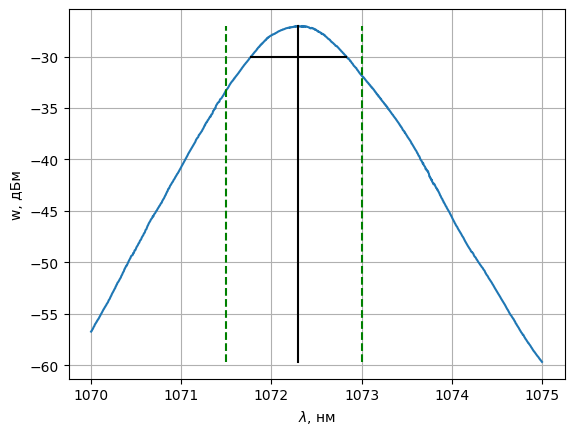

In [4]:
# Функция, извлекающая информацию о пике излучения на спектре в заданном диапазоне длин волн. 
# При сообщении дополнительного параметра out = 1 выводит график. 

def analyze_spectrum(spectrum, lmbda_1, lmbda_2, out = 0):
    
    lmbdas = spectrum['lmbdas']
    value = spectrum['value']
    i_value = 10**(spectrum['value']/10)
    idx1 = np.where(lmbdas == lmbda_1)[0][0]
    idx2 = np.where(lmbdas == lmbda_2)[0][0]

    all_power = simpson(i_value, x = lmbdas)
    peak_power = simpson(i_value[idx1:idx2], x = lmbdas[idx1:idx2])
    power_share = peak_power/all_power
    
    power_peak = max(value[idx1:idx2])
    central_lmbda = lmbdas[np.where(value == power_peak)[0][0]]

    left = lmbdas[np.where(value[idx1:idx2] >= power_peak-3)[0][0]]
    right = lmbdas[np.where(value[idx1:idx2] >= power_peak-3)[0][-1]]
    width = right - left

    if out == 1:
        plt.plot(lmbdas, value, label = spectrum['Pout'])
        plt.plot([lmbda_1, lmbda_1], [min(value), power_peak], 'g--')
        plt.plot([lmbda_2, lmbda_2], [min(value), power_peak], 'g--')

        plt.plot([central_lmbda, central_lmbda], [min(value), power_peak], color = 'black')
        plt.plot([central_lmbda - width/2, central_lmbda + width/2], [power_peak-3, power_peak-3], color = 'black') 
        plt.grid() 

        plt.xlabel(r'$\lambda$, нм')
        plt.ylabel('w, дБм')

    return central_lmbda, width, power_peak, power_share


analyze_spectrum(non_raman['56']['data'][-1], 1071.5, 1073, 1)

Исследуем спектры для различных номинальных мощностей. Занесем полученные даные в датафрейм.

In [5]:
colnames = ['Power', 'central_lmbda', 'width', 'power_peak', 'power_share']

result_30 = [(item['Pout'], *analyze_spectrum(item, 1070, 1075)) for item in non_raman['30']['data']]
df_30 = pd.DataFrame(result_30, columns = colnames)
df_30 = df_30.sort_values(by = ['Power'])

result_42 = [(item['Pout'], *analyze_spectrum(item, 1070, 1075)) for item in non_raman['42']['data']]
df_42 = pd.DataFrame(result_42, columns = colnames)
df_42 = df_42.sort_values(by = ['Power'])

result_56 = [(item['Pout'], *analyze_spectrum(item, 1070, 1075)) for item in non_raman['56']['data']]
df_56 = pd.DataFrame(result_56, columns = colnames)
df_56 = df_56.sort_values(by = ['Power'])

dfs = dict.fromkeys(Powers)
dfs['30'] = df_30
dfs['42'] = df_42
dfs['56'] = df_56

df_30


,Power,central_lmbda,width,power_peak,power_share
0,30.0,1072.3067,0.7300,-35.337,1.000027
2,55.8,1072.3233,0.7333,-33.020,0.999991
3,190.0,1072.3133,0.7600,-28.367,0.999909
4,312.0,1072.3100,0.8300,-26.823,1.000005
5,450.0,1072.2933,0.8866,-25.754,0.999998
1,560.0,1072.2600,0.9133,-25.678,0.999909


Посмотрим на некотрые полученные зависимости:

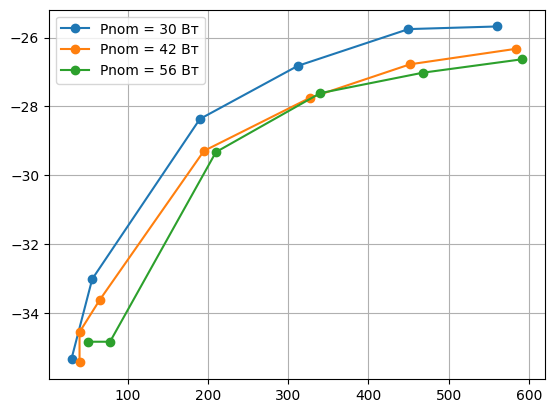

In [6]:
# Зависимость уровня пика от мощности излучения
fig, ax = plt.subplots()
plt.plot(df_30['Power'], df_30['power_peak'], 'o-', label = 'Pnom = 30 Вт')
plt.plot(df_42['Power'], df_42['power_peak'], 'o-', label = 'Pnom = 42 Вт')
plt.plot(df_56['Power'], df_56['power_peak'], 'o-', label = 'Pnom = 56 Вт')
plt.grid()
plt.legend()

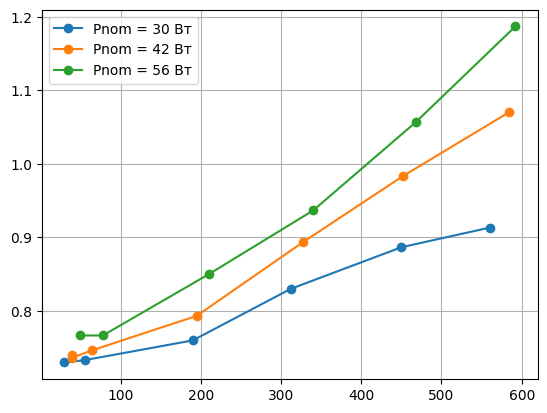

In [7]:
# Зависимость ширины спектра от мощности излучения
fig, ax = plt.subplots()
plt.plot(df_30['Power'], df_30['width'], 'o-', label = 'Pnom = 30 Вт')
plt.plot(df_42['Power'], df_42['width'], 'o-', label = 'Pnom = 42 Вт')
plt.plot(df_56['Power'], df_56['width'], 'o-', label = 'Pnom = 56 Вт')
plt.grid()
plt.legend()


Установим наличие корреляции между температурой высвета и шириной спектра при помощи теста Спирмана, реалтзованного в библиотеке `scipy.stats` 

Pnom =  30
Корреляция есть
Переменные связаны напрямую
Pnom =  42
Корреляция есть
Переменные связаны напрямую
Pnom =  56
Корреляция есть
Переменные связаны напрямую


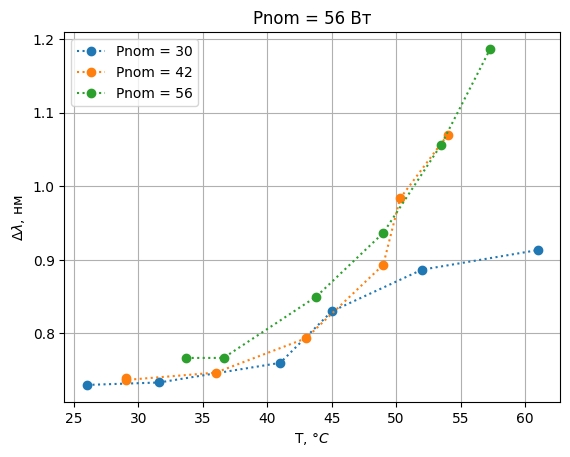

In [8]:

def determine_correlation(x, y):    
    res_spear_s, res_spear_p = stats.spearmanr(x,y)
    if res_spear_p < 0.05:
        print("Корреляция есть")
    else:
        print("Корреляции нет")
    if res_spear_s < 0:
        print("Переменные обратно взаимосвязаны")
    else:
        print("Переменные связаны напрямую")


fig, ax = plt.subplots()
for power in Powers:
    print('Pnom = ', power)
    x = get_temp(power, dfs[power]['Power'])
    y = dfs[power]['width']    
    plt.plot(x, y, 'o:', label = 'Pnom = ' + power)   
    determine_correlation(x,y)

ax.set_xlabel(r'T, $\degree C$')
ax.set_ylabel(r'$\Delta \lambda$, нм')
plt.grid()
plt.title(f'Pnom = {power} Вт')
plt.legend()





# 3. Рамановское излучение
Перейдем к исследованию рамановского излучения. Данные были получены измерением спектров на большем диапазоне длин волн.

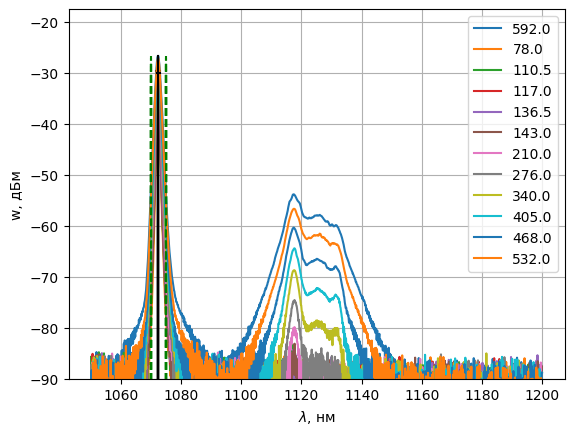

In [9]:
result_raman_1072 = [(item['Pout'], *analyze_spectrum(item, 1070, 1075, 1)) for item in raman['56']['data']]
result_raman_1120 = [(item['Pout'], *analyze_spectrum(item, 1100, 1150)) for item in raman['56']['data']]

df_raman_1072 = pd.DataFrame(result_raman_1072, columns = colnames)
df_raman_1072 = df_raman_1072.sort_values(by = ['Power'])


df_raman_1120 = pd.DataFrame(result_raman_1120, columns = colnames)
df_raman_1120 = df_raman_1120.sort_values(by = ['Power'])

plt.legend()
plt.ylim(-90, )
plt.grid()

Известно, что стоксова волна 
$
{\displaystyle \omega _{c}=\omega _{0}-\Omega } 
$
экспоненциально усиливается по мере распространения в среде:
$${\displaystyle I_{c}=I_{c0}e^{gI_{0}z}}$$
При этом интенсивность связана с мощностью как $I = P / S_{eff}$, где $S_{eff} = \pi * r^2$. Соответсвенно уравнение принимает вид :
$${\displaystyle P_{c}=P_{c0}e^{{g  P_{0}z}/S_{eff}}}$$
При фиксированном значении $z$  зависимость от мощности в волокне позволяет определить коэффициент усиления $g$.

Коэффициент усиления g = 9.30E-05 м/Вт


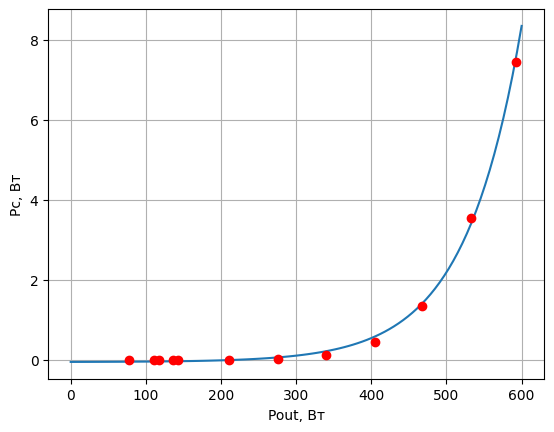

In [10]:
def f_exp(x, a, b, c):
    return a * np.exp(b* x) + c

fig, ax = plt.subplots()
# ax1 = ax.twinx()
# ax1.plot(df_raman_1072['Power'], df_raman_1072['power_share'] * df_raman_1072['Power'] , 'o')


p0 = (0.01, 0.011, 0)
s_popt, s_pcov = curve_fit(f_exp, df_raman_1120['Power'], df_raman_1120['power_share'] * df_raman_1120['Power'], p0 = p0)
ax.plot(pp, f_exp(pp, *s_popt))
ax.plot(df_raman_1120['Power'], df_raman_1120['power_share'] * df_raman_1120['Power'] , 'ro')

ax.set_xlabel('Pout, Вт')

ax.set_ylabel('Pc, Вт')
ax1.set_ylabel('P0, Вт')
ax.grid()

r = 164e-3
S_eff = np.pi* r**2
z = 12
b = s_popt[1] #показатель экспоненты
g = b * S_eff /z


s_format = "{:.2E}"
print(f'Коэффициент усиления g = {s_format.format(g)} м/Вт')


# print(f'Относительные погрешности: {item for item in np.diag(s_pcov)/s_popt} ')


# Вывод:
1. Установлено наличие корреляции между шириной спектра излучения и температурой высвета.
2. Регрессионным методом была проверена теоретическая зависимости мощности рамановского излучения. Из коэффициента апрксимации определен коээффицент усиления в волокне.